In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing

### Define Data Path and Load period

In [2]:
path = '../data-sets/KDD-Cup/data/'
period_path = '../data-sets/KDD-Cup/period/period.csv'
files_name = [i for i in os.listdir(path) if 'Anomaly' in i] #remove irrelevant files
files_name.sort(key = lambda x : x.split('_')[0]) #sort by id

In [3]:
period = pd.read_csv(period_path) #load period file calculated by fourier transform
period.head()

,File_name,Period
0,001_UCR_Anomaly_35000.txt,210
1,002_UCR_Anomaly_35000.txt,208
2,003_UCR_Anomaly_35000.txt,209
3,004_UCR_Anomaly_2500.txt,80
4,005_UCR_Anomaly_4000.txt,24


In [4]:
log_dir = '../log/'
res_dir = ['autoencoder','stl','matrix_profile','lstm','fft']
print(res_dir)

['autoencoder', 'stl', 'matrix_profile', 'lstm', 'fft']


In [5]:
name = files_name[16]
data = pd.read_csv(path+name,header=None)
if data.shape == (1,1):
    tmp = [i for i in data[0][0].split(' ') if i!= '']
    data = pd.DataFrame({0:tmp}).astype('float')
split_index  = int(name.split('.')[0].split('_')[3]) #get split index
TIME_STEPS = int(period[period['File_name'] == name]['Period'])

In [6]:
name

'017_UCR_Anomaly_5000.txt'

### Load the Residual data

In [6]:
a = np.loadtxt(log_dir+'autoencoder/'+name+'.txt')
l = np.loadtxt(log_dir+'lstm/'+name+'.txt')
m = np.loadtxt(log_dir+'matrix_profile/'+name)
s = np.loadtxt(log_dir+'stl/'+name+'.txt')
f = np.loadtxt(log_dir+'fft/'+name+'.txt')

It is clear that for residual of matrix profile, we need to subtract the split index to match the length of other residuals

fft delete the last TIMESTEPS Data

In [7]:
a.shape,l.shape,m.shape,s.shape,f.shape,split_index,len(data),TIME_STEPS

((25000,), (25000,), (30000,), (25000,), (24833,), 5000, 30000, 166)

In [8]:
m = m[split_index::]
m.shape

(25000,)

### Clip Residual to avoid Nan

There will be some nan in matrix profile residual & STL redidual. They are located in the start and the end of the sequence.

In [9]:
np.argwhere(np.isnan(m)).shape,np.argwhere(np.isnan(s)).shape,np.argwhere(np.isnan(f)).shape

((165, 1), (83, 1), (0, 1))

After we calculate the mean and std of Non-Nan value, we will fill the nan value as zero. Since ananomalies are unlikely located in the edge of sequence (very difficult to detect), zero value means the residual is small, which can not make nan value located in the sequence of anomalies.

### Perform Ensemble using standard deviation based weight

In [10]:
std_a,std_l,std_m,std_s,std_f = np.nanstd(a),np.nanstd(l),np.nanstd(m),np.nanstd(s),np.nanstd(f)

w_a = (np.nanmax(a) - np.nanmean(a))/ np.nanstd(a)
w_l = (np.nanmax(l) - np.nanmean(l))/ np.nanstd(l)
w_m = (np.nanmax(m) - np.nanmean(m))/ np.nanstd(m)
w_s = (np.nanmax(s) - np.nanmean(s))/ np.nanstd(s)
w_f = (np.nanmax(f) - np.nanmean(f))/ np.nanstd(f)

summation = sum([w_a,w_l,w_m,w_s,w_f])
w_a,w_l,w_m,w_s,w_f = w_a/summation,w_l/summation,w_m/summation,w_s/summation,w_f/summation

print("The weight of autoencoder is {}, weight of lstm is {}, weight of matrix profile is {}, weight of stl is {}, weight of fft {}".format(w_a,w_l,w_m,w_s,w_f))

The weight of autoencoder is 0.13387294952775702, weight of lstm is 0.18066422632337148, weight of matrix profile is 0.33420384790252183, weight of stl is 0.1904957697925763, weight of fft 0.16076320645377334


Here we fill nan value to 0

In [11]:
a = np.nan_to_num(a, copy=True, nan=0.0)
l = np.nan_to_num(l, copy=True, nan=0.0)
m = np.nan_to_num(m, copy=True, nan=0.0)
s = np.nan_to_num(s, copy=True, nan=0.0)
f = np.nan_to_num(f, copy=True, nan=0.0)

### Normalization on residual

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
a = min_max_scaler.fit_transform(a.reshape(-1, 1))
l = min_max_scaler.fit_transform(l.reshape(-1, 1))
m = min_max_scaler.fit_transform(m.reshape(-1, 1))
s = min_max_scaler.fit_transform(s.reshape(-1, 1))
f = min_max_scaler.fit_transform(f.reshape(-1, 1))

f = np.append(f,[0 for i in range(TIME_STEPS+1)]).reshape(-1, 1)

### Create sum of weights residuals

In [13]:
weight_res = w_a * a + w_l*l + w_m*m + w_s*s + w_f*f
# weight_res = .25 * a + .25*l + .25*m + .25*s  + .25*f

# weight_res =  w_m*m + w_s*s + w_f*f

center = np.argmax(weight_res[TIME_STEPS:-1-TIME_STEPS]) + split_index  + TIME_STEPS #the center is the point with largest residual

### Also visualize the maximum residual point detected by ont algorithm
center_a = np.argmax(a[TIME_STEPS:-1-TIME_STEPS]) + split_index + TIME_STEPS
center_l = np.argmax(l[TIME_STEPS:-1-TIME_STEPS]) + split_index + TIME_STEPS
center_m = np.argmax(m[TIME_STEPS:-1-TIME_STEPS]) + split_index + TIME_STEPS
center_s = np.argmax(s[TIME_STEPS:-1-TIME_STEPS]) + split_index + TIME_STEPS
center_f =  np.argmax(f[TIME_STEPS:-1-TIME_STEPS]) + split_index + TIME_STEPS

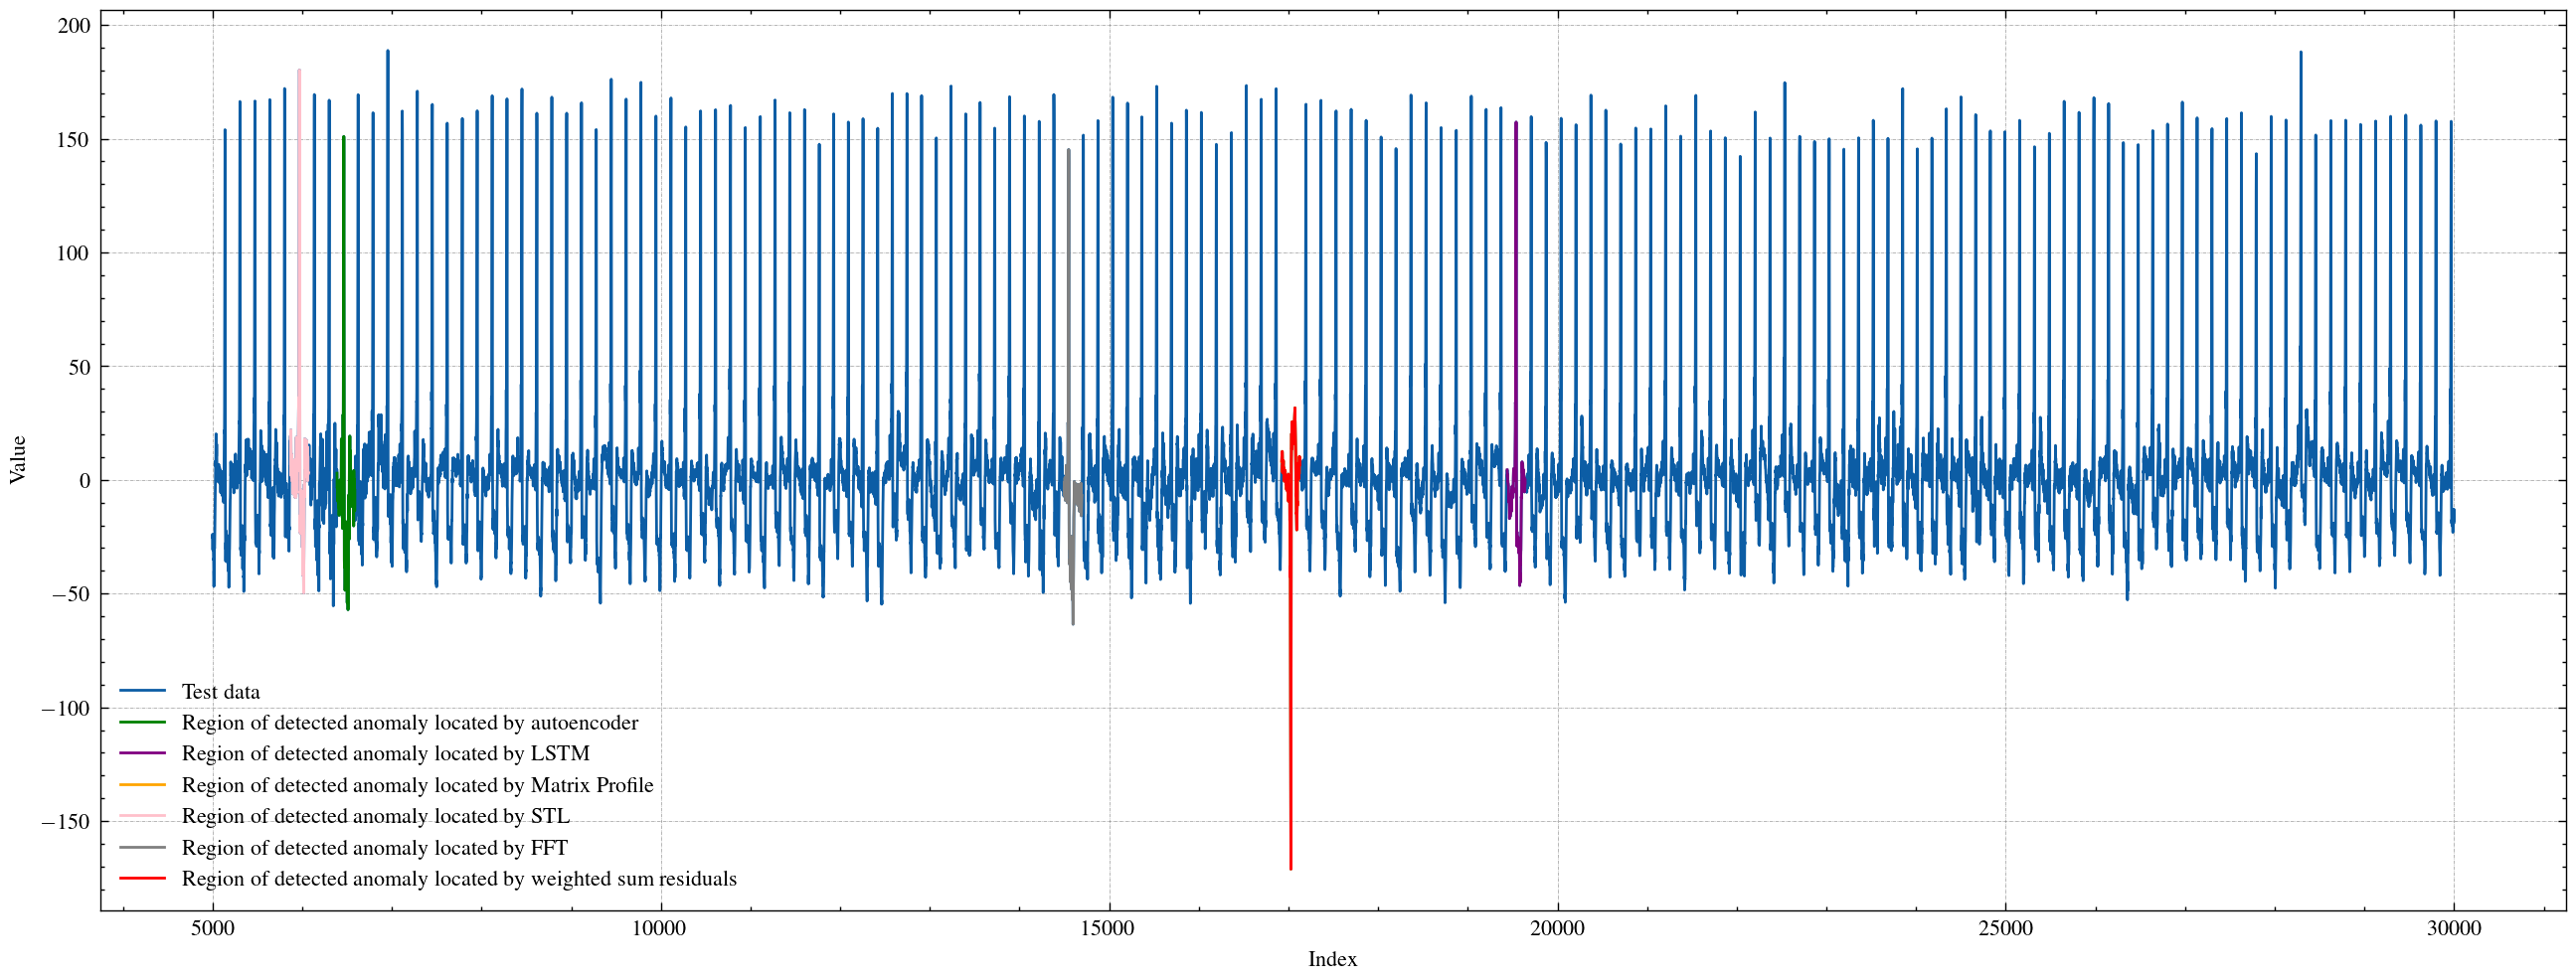

In [14]:
plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[16,6],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.plot(range(split_index,len(data)),data[split_index:],label='Test data')

plt.plot(range(center_a-100,center_a+100),data[center_a-100:center_a+100],color='green',label = 'Region of detected anomaly located by autoencoder')
plt.plot(range(center_l-100,center_l+100),data[center_l-100:center_l+100],color='purple',label = 'Region of detected anomaly located by LSTM')
plt.plot(range(center_m-100,center_m+100),data[center_m-100:center_m+100],color='orange',label = 'Region of detected anomaly located by Matrix Profile')
plt.plot(range(center_s-100,center_s+100),data[center_s-100:center_s+100],color='pink',label = 'Region of detected anomaly located by STL')
plt.plot(range(center_f-100,center_f+100),data[center_f-100:center_f+100],color='grey',label = 'Region of detected anomaly located by FFT')

plt.plot(range(center-100,center+100),data[center-100:center+100],color='red',label = 'Region of detected anomaly located by weighted sum residuals')

plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()